# Click Consensus

Banfield et al. (2015) compute the *consensus* for each subject. Consensus is defined as

$$
C = \frac{n_c}{n}
$$

where $n_c$ is the number of volunteers who agreed on the majority classification of a subject, and $n$ is the total number of volunteers who attempted to classify the subject.

There are two components to a classification. The first is the combination of radio components that correspond with a single source. There are often multiple radio contours per subject, and volunteers must decide which contours correspond with the same source. The second is the host galaxy selection. This is represented by volunteers clicking on the infrared image to identify a host galaxy.

Banfield et al. compute $n_c$ by counting how many volunteers agree on the combination of radio components and the host galaxy ID for all radio components in the subject. However, the associated code seems to ignore the amount of agreement on host galaxy location while computing $n_c$. In this notebook, I will compute a mean consensus that includes agreement on host galaxy location, and compare this to the value obtained in the paper.

The method used by Banfield et al. to identify a host galaxy from many volunteers' clicks is as follows. A kernel density estimator is applied to the volunteers' clicks. The density is estimated for all pixels in the image. A local maximum filter is applied to the density to find click density peaks. This yields a) the number of different objects clicked on, and b) the location of the infrared host galaxy (by finding the maximum peak). No method is described for deciding which host was clicked on by any particular volunteer. Additionally, this method is somewhat slow due to computing the density across 250000 data points per subject, and somewhat fragile as two volunteers clicking on the same location will result in an invalid density estimation. In this notebook, I will use a different method to identify the host galaxy that attempts to solve both of these problems, and also provides a mechanism for finding which host was clicked on by any given volunteer. I will use a clustering algorithm to cluster the clicks and fit a gaussian to each cluster. The mean of the gaussian represents the infrared host associated with each cluster, and the cluster membership of a click allows us to find the infrared host associated with each click. This can then be used to calculate $n_c$ and hence consensus.

## Values of $k$

If we were to $k$-means cluster, then the first question is, "what should $k$ be?". It would be nice to know what values of $k$ are realistic for the dataset. Fortunately, the number of click peaks is output by Willett's RGZ consensus calculation, so we can just run that over a thousand or so subjects and find the max.

In [4]:
import collections
import pprint
import sys
import timeit
import warnings

import matplotlib.pyplot
import numpy
import scipy.stats
import sklearn.cluster
import sklearn.mixture


sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show
import crowdastro.rgz_analysis.consensus

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

In [5]:
# This takes a while to run.
if False:
    largest_n_peaks = 0
    n = 1000
    for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas'}).limit(n):
        consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
        for answer in consensus['answer'].values():
            n_peaks = answer.get('peak_data', {}).get('npeaks', 0)
            if n_peaks > largest_n_peaks:
                largest_n_peaks = n_peaks
                print('New max: {} ({})'.format(n_peaks, subject['zooniverse_id']))

That's unexpectedly high. Let's have a look at ARG0003rls (74 clicks!) &mdash; maybe it's special in some way, or maybe KDE fails for it and we get strange results.

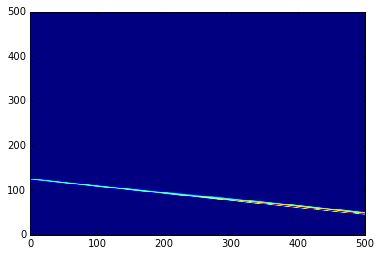

In [6]:
s = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003rls'})
c = crowdastro.rgz_analysis.consensus.consensus(s['zooniverse_id'])
matplotlib.pyplot.pcolor(c['answer'][636.233]['peak_data']['Z'])
matplotlib.pyplot.show()

So it looks like KDE failed. Perhaps there were very few clicks?

In [7]:
s['classification_count']

22

Let's plot the clicks and look.

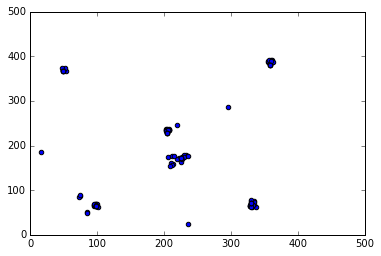

In [8]:
classifications = crowdastro.data.db.radio_classifications.find({'subject_ids': s['_id']})
xs = []
ys = []
for classification in classifications:
    clicksets = [a['ir'] for a in classification['annotations'] if 'ir' in a]
    for clicks in clicksets:
        if clicks != 'No Sources':
            for click in clicks.values():
                xs.append(float(click['x']))
                ys.append(float(click['y']))
matplotlib.pyplot.scatter(xs, ys)
matplotlib.pyplot.xlim((0, 500))
matplotlib.pyplot.ylim((0, 500))
matplotlib.pyplot.show()

Maybe the clicks overlap, and as a result, KDE breaks? We can check this.

In [10]:
l = len(list(zip(xs, ys))) - len(set(zip(xs, ys)))
print(l == 0, l)

False 19


It seems that 19 people clicked on the same point, and this broke KDE.

## PG-means clustering

We will now follow the PG-means clustering algorithm to cluster the clicks, but using a Gaussian mixture model rather than $k$-means clustering. I can't test this on the same subject used in Banfield et al. (2015), since that's not from the ATLAS survey, but I'll find a subject and use that.

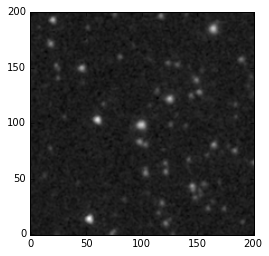

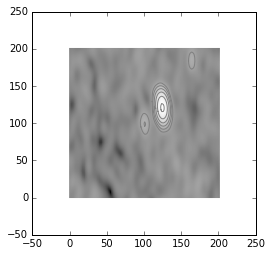

In [11]:
# subject = crowdastro.data.get_random_subject()
subject = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003sfk'})
crowdastro.show.ir(subject)
matplotlib.pyplot.show()
crowdastro.show.radio(subject)
crowdastro.show.contours(subject)
matplotlib.pyplot.show()

Let's see what Willett's code gives us.

In [12]:
consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
for answer in consensus['answer'].values():
    print(answer['peak_data']['npeaks'])

2
2
1


Let's start by pulling out all the radio classifications and finding the plurality classification.

In [13]:
def make_annotation_signature(annotation):
    """Generates the signature associated with an annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # We want to turn the radio classifications into a unique signature. I can just take all the xmax's and ymax's
    # and put them into some tuples (xmaxs, ymaxs).
    
    # Having no contours is a special case; () to avoid type errors (it's special but it's still valid!)
    if annotation['radio'] == 'No Contours':
        return ()

    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates the signature associated with a radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature


n_signatures = collections.Counter()

for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
    classification_signature = make_classification_signature(classification)
    n_signatures[classification_signature] += 1

plurality_radio_signature = max(n_signatures, key=n_signatures.get)

Now we need to cluster the clicks of anyone who agreed with the plurality radio signature. In general, there might be multiple clicks. Willett chooses to just use the first click, so we'll do that too. While we're here, we'll check that dividing out the number of people who agree with the plurality radio signature by the total number of classifications gives us the same consensus value as the original code.

Consensus (MatthewJA): 60.00%
Consensus (willettk): 63.16%


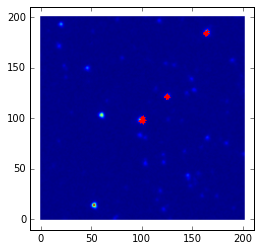

In [14]:
n_agree = 0
n_total = 0
signature_to_clicks = collections.defaultdict(list)
for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
    classification_signature = make_classification_signature(classification)
    if classification_signature == plurality_radio_signature:
        n_agree += 1
        # Format: [{'ir': {id: {'y': y}}}]
        # We'll need to pull out a {signature: [coords_of_first_click]} map to be consistent - each signature should
        # have a different set of clusters, as it represents a different object.
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue
            
            first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            signature_to_clicks[annotation_signature].append(first_click)

    n_total += 1

original_consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
original_consensus = original_consensus['n_users'] / original_consensus['n_total']
print('Consensus (MatthewJA): {:.02%}'.format(n_agree / n_total))
print('Consensus (willettk): {:.02%}'.format(original_consensus))

ir = crowdastro.data.get_ir(subject)
matplotlib.pyplot.imshow(ir, origin='lower')
for clicks in signature_to_clicks.values():
    clicks = numpy.array(clicks, dtype=float)
    clicks *= crowdastro.config.get('click_to_fits')
    clicks[:, 1] = 200 - clicks[:, 1]
    matplotlib.pyplot.scatter(clicks[:, 0], clicks[:, 1], marker='+', c='r')
matplotlib.pyplot.show()

It seems I have an extra data point that the RGZ code discards. I'm not sure why (or if it matters) so I'll investigate that later. The clicks work fine. Now I'll implement the PG-means algorithm and run it on the clicks. I'll first try it on the concatenated clicks, so I can confirm that the clustering works, then I'll run it on the separated radio signatures to find the means and membership.

In [15]:
def pg_means(points, significance=0.1, projections=12):
    """Cluster points with the PG-means algorithm."""
    k = 1
    
    while True:
        # Fit a Gaussian mixture model with k components.
        gmm = sklearn.mixture.GMM(n_components=k)
        gmm.fit(points)
        
        for _ in range(projections):
            # Project the data to one dimension.
            projection_vector = numpy.random.random(size=(2,))
            projected_points = points @ projection_vector
            # Project the model to one dimension.
            # We need the CDF in one dimension, so we'll sample some data points and project them.
            n_samples = 1000
            samples = gmm.sample(n_samples) @ projection_vector
            samples.sort()
            
            def cdf(x):
                for sample, y in zip(samples, numpy.arange(n_samples) / n_samples):
                    if sample >= x:
                        break
                return y
            
            _, p_value = scipy.stats.kstest(projected_points, numpy.vectorize(cdf))
            if p_value < significance:
                # Reject the null hypothesis.
                break
        else:
            # Null hypothesis was not broken.
            return gmm
        
        k += 1

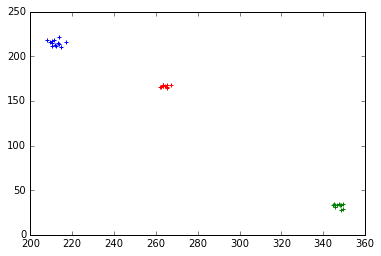

In [16]:
clicks = numpy.concatenate(list(signature_to_clicks.values()))
gmm = pg_means(clicks)
c0_clicks = clicks[gmm.predict(clicks) == 0]
c1_clicks = clicks[gmm.predict(clicks) == 1]
c2_clicks = clicks[gmm.predict(clicks) == 2]
matplotlib.pyplot.scatter(c0_clicks[:, 0], c0_clicks[:, 1], c='r', marker='+')
matplotlib.pyplot.scatter(c1_clicks[:, 0], c1_clicks[:, 1], c='g', marker='+')
matplotlib.pyplot.scatter(c2_clicks[:, 0], c2_clicks[:, 1], c='b', marker='+')
matplotlib.pyplot.show()

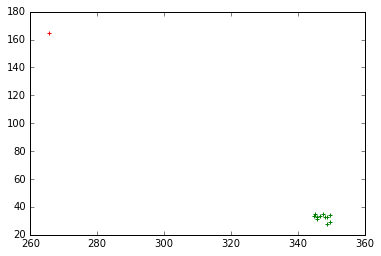

In [17]:
clicks = numpy.array(signature_to_clicks[((168.52139993210605,), (27.36430937927985,))], dtype=float)
gmm = pg_means(clicks)
c0_clicks = clicks[gmm.predict(clicks) == 0]
c1_clicks = clicks[gmm.predict(clicks) == 1]
matplotlib.pyplot.scatter(c0_clicks[:, 0], c0_clicks[:, 1], c='r', marker='+')
matplotlib.pyplot.scatter(c1_clicks[:, 0], c1_clicks[:, 1], c='g', marker='+')
matplotlib.pyplot.show()

The code clusters the three sets of points in the first plot, and correctly identifies the outlier in the second plot. We can now find the "plurality click" by getting the mean of the cluster with the highest weight. We'd expect this to be the mean of the red cluster above.

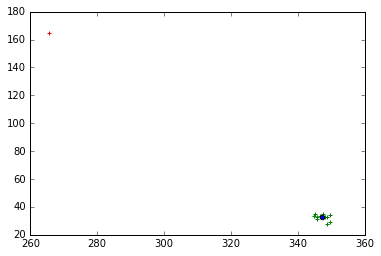

In [18]:
plurality_click = gmm.means_[gmm.weights_.argmax()]

matplotlib.pyplot.scatter(c0_clicks[:, 0], c0_clicks[:, 1], c='r', marker='+')
matplotlib.pyplot.scatter(c1_clicks[:, 0], c1_clicks[:, 1], c='g', marker='+')
matplotlib.pyplot.scatter([plurality_click[0]], [plurality_click[1]], c='b', marker='o')
matplotlib.pyplot.show()

The plurality click has been identified as being in the middle of the red cluster, as expected.

Now, let's bundle up all this code into one function. Given a subject, we want to know:

- The plurality radio signatures.
- The plurality clicks and their associated radio signature.
- How many people classified the subject.
- How many people agree with the plurality radio signatures.
- How many people agree with the plurality clicks *and* the plurality radio signatures.

We will then compute the consensus for the above image using the method from Banfield et al., and compare this to our method which accounts for clicks.

In [19]:
def find_plurality_radio_signature(subject):
    n_signatures = collections.Counter()
    
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        n_signatures[classification_signature] += 1

    plurality_radio_signature = max(n_signatures, key=n_signatures.get)
    return plurality_radio_signature

def subject_consensus(subject):
    """
    Returns dict:
        plurality_radio_signature: Unique signature of the plurality radio combination.
        plurality_clicks: Map from radio signature to IR source identified by volunteers' clicks.
        n_total: Total number of volunteers that classified this subject.
        n_agree: Total number of volunteers that agree on both the radio combination and IR sources.
        n_agree_radio: Total number of volunteers that agree on the radio combination, ignoring IR.
    """
    n_total = 0
    n_agree = 0
    n_agree_radio = 0

    plurality_radio_signature = find_plurality_radio_signature(subject)
    
    # Find how many volunteers agree on the radio combination.
    # Separate clicks into which radio signature they are associated with.
    # Only do this if the volunteer agrees on the radio classification.
    signature_to_clicks = collections.defaultdict(list)
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        n_total += 1

        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        n_agree_radio += 1
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            # We ignore multiple clicks and instead just use the first click.
            if annotation['ir'] == 'No Sources':
                first_click = (-1, -1)
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            signature_to_clicks[annotation_signature].append(first_click)
    
    # For each radio signature, cluster the clicks and find the plurality click.
    plurality_clicks = {}
    signature_to_cluster = {}
    signature_to_gmm = {}
    for radio_signature, clicks in signature_to_clicks.items():
        gmm = pg_means(clicks)
        signature_to_gmm[radio_signature] = gmm
        signature_to_cluster[radio_signature] = gmm.weights_.argmax()
        plurality_clicks[radio_signature] = gmm.means_[gmm.weights_.argmax()]
    
    # Find how many volunteers agree with the plurality clicks *and* the plurality radio signature.
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            if annotation['ir'] == 'No Sources':
                first_click = (-1, -1)
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            cluster = signature_to_gmm[annotation_signature].predict([first_click])
            if cluster != signature_to_cluster[radio_signature]:
                break
        else:
            # All agreed!
            n_agree += 1
    
    return {
        'plurality_radio_signature': plurality_radio_signature,
        'plurality_clicks': plurality_clicks,
        'n_total': n_total,
        'n_agree': n_agree,
        'n_agree_radio': n_agree_radio,
    }

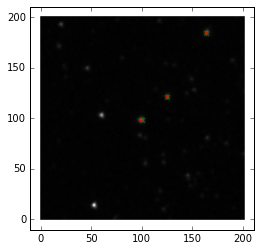

In [20]:
# Let's try it out.
# I'll plot RGZ's IR sources and my IR sources for the test subject from earlier.
test_subject = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003sfk'})
# My IR sources...
plurality_clicks_me = numpy.array(list(subject_consensus(test_subject)['plurality_clicks'].values()))
# RGZ's IR sources...
rgz_consensus = crowdastro.rgz_analysis.consensus.consensus(test_subject['zooniverse_id'])
plurality_clicks_rgz = [answer['ir_peak'] for answer in rgz_consensus['answer'].values()]

ir = crowdastro.data.get_ir(subject)
matplotlib.pyplot.imshow(ir, origin='lower', cmap='gray')
plurality_clicks_me *= crowdastro.config.get('click_to_fits')
matplotlib.pyplot.scatter(plurality_clicks_me[:, 0],
                          crowdastro.config.get('fits_image_height') - plurality_clicks_me[:, 1],
                          c='g', marker='x')
plurality_clicks_rgz *= numpy.array([200 / 500, 200 / 500])
matplotlib.pyplot.scatter(plurality_clicks_rgz[:, 0],
                          crowdastro.config.get('fits_image_height') - plurality_clicks_rgz[:, 1],
                          c='r', marker='+')
matplotlib.pyplot.show()

So our results line up! Let's try timing them.

In [23]:
t = timeit.Timer(lambda: subject_consensus(
    list(crowdastro.data.db.radio_subjects.aggregate([
        {'$match': {'metadata.survey': 'atlas', 'state': 'complete'}},
        {'$sample': {'size': 1}}]))[0]
    ))
print('Time (MatthewJA): {:.02} s'.format(t.timeit(number=10)))

t = timeit.Timer(lambda: crowdastro.rgz_analysis.consensus.consensus(
    list(crowdastro.data.db.radio_subjects.aggregate([
        {'$match': {'metadata.survey': 'atlas', 'state': 'complete'}},
        {'$sample': {'size': 1}}]))[0]['zooniverse_id']
    ))
print('Time (willettk): {:.02} s'.format(t.timeit(number=10)))  # Note that I don't query the subjects DB twice. TODO

Time (MatthewJA): 1.7 s
Time (willettk): 5.9 s


In [24]:
# TODO(MatthewJA): Resolve bug where the number of clusters can exceed the number of samples.
# Possibly increase α?

I also want to see how much the consensuses differ.

In [27]:
for subject in list(crowdastro.data.db.radio_subjects.aggregate([
        {'$match': {'metadata.survey': 'atlas', 'state': 'complete'}},
        {'$sample': {'size': 5}}])):
    c_me = subject_consensus(subject)
    c_rgz = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
    print('Consensus (MatthewJA): {:.02%}'.format(c_me['n_agree'] / c_me['n_total']))
    print('Consensus (willettk): {:.02%}'.format(c_rgz['n_users'] / c_rgz['n_total']))
    print('-' * 40)

Consensus (MatthewJA): 35.00%
Consensus (willettk): 52.94%
----------------------------------------
Consensus (MatthewJA): 35.00%
Consensus (willettk): 66.67%
----------------------------------------
Consensus (MatthewJA): 5.00%
Consensus (willettk): 64.71%
----------------------------------------
Consensus (MatthewJA): 0.00%
Consensus (willettk): 38.89%
----------------------------------------
Consensus (MatthewJA): 30.00%
Consensus (willettk): 43.75%
----------------------------------------


A consensus of 0% doesn't really make sense, so something odd is going on there.